In [2]:
'''
Importing the necessary libraries and modules.
The dataset file is located in a local directory
'''

'''
Importing libraries and loading dataset
should be hosted in different cells for 
the sake of convenience.
'''

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels 
import random


In [3]:
## Load dataset from local directory
file_path = '../ESS2e03_6.csv'
df = pd.read_csv(file_path, encoding='latin1')

display(df.describe().T)

C:\Users\KIEN\AppData\Local\Temp\ipykernel_14748\3853491042.py:3: DtypeWarning: Columns (165) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='latin1')


,count,mean,std,min,25%,50%,75%,max
essround,47537.0,2.000000e+00,0.000000e+00,2.000000,2.000000,2.000000,2.000000,2.000000e+00
edition,47537.0,3.600000e+00,8.881878e-16,3.600000,3.600000,3.600000,3.600000,3.600000e+00
idno,47537.0,1.685002e+07,9.046804e+07,1.000000,1459.000000,3706.000000,47885.000000,9.214130e+08
tvtot,47537.0,4.557019e+00,5.063879e+00,0.000000,3.000000,4.000000,6.000000,9.900000e+01
tvpol,47537.0,4.236174e+00,1.234226e+01,0.000000,1.000000,2.000000,2.000000,9.900000e+01
...,...,...,...,...,...,...,...,...
supqmm,44463.0,9.575557e+00,1.370726e+01,1.000000,2.000000,10.000000,11.000000,9.900000e+01
supqyr,45961.0,2.123905e+03,9.700956e+02,2004.000000,2004.000000,2004.000000,2005.000000,9.999000e+03
dweight,47537.0,9.999963e-01,4.733246e-01,0.001600,0.835500,1.000000,1.055600,5.983300e+00
pspwght,47537.0,1.000244e+00,5.586856e-01,0.001502,0.661499,0.919958,1.194815,6.274307e+00


In [4]:
## Wanted to see which variables are correlated with health most
correlation = df.corr(numeric_only=True)['health']

In [5]:
## Filter out correlations that is significant with health

print("Top 5 strongest positive correlation to health, according to the dataset:\n",
      correlation.sort_values(ascending=False).head(6))

print()
print("Top 5 strongest negative correlation to health, according to the dataset:\n",
      correlation.sort_values(ascending=True).head(5))


Top 5 strongest positive correlation to health, according to the dataset:
 health     1.000000
actvgrs    0.394656
tmcnsdc    0.360070
gdsprt     0.358119
rtrd       0.338638
lfintr     0.301511
Name: health, dtype: float64

Top 5 strongest negative correlation to health, according to the dataset:
 hlthhmp   -0.416722
rtryr     -0.280256
wntrtr    -0.279271
clhwkrc   -0.267854
pdjobev   -0.262884
Name: health, dtype: float64


In [6]:
## Use a different method to calculate correlation
correlation2 = df.corr(method = 'spearman', 
                       numeric_only = True,
                       )['health']

In [7]:
## Filter out the top 10, positive and negative
print("Top 5 strongest positive correlation to health, according to the dataset:\n",
      correlation2.sort_values(ascending=False).head(6))

print()
print("Top 5 strongest negative correlation to health, according to the dataset:\n",
      correlation2.sort_values(ascending=True).head(5))

Top 5 strongest positive correlation to health, according to the dataset:
 health     1.000000
agea       0.385878
actvgrs    0.370464
tmcnsdc    0.363149
rtrd       0.340615
gdsprt     0.339642
Name: health, dtype: float64

Top 5 strongest negative correlation to health, according to the dataset:
 hlthhmp   -0.525245
edlvgr    -0.476925
edlvpt    -0.472285
usmdprs   -0.384314
yrbrn     -0.380614
Name: health, dtype: float64


In [8]:
## The selected columns would contribute to the analysis of the dataset.

print("Top 10 strongest positive correlation to health, both methods:")
print(correlation.sort_values(ascending=False).head(10).index.tolist())
print(correlation2.sort_values(ascending=False).head(10).index.tolist())
## Although the two methods are different, they yield similar results.

correlation_list_pos_1 = correlation.sort_values(ascending=False).head(10).index.tolist()
correlation_list_pos_2 = correlation2.sort_values(ascending=False).head(10).index.tolist()
common_pos_correlation = [item for item in correlation_list_pos_1 if item in correlation_list_pos_2]

print()
print("Top 10 strongest negative correlation to health, both methods:")
print(correlation2.sort_values(ascending=True).head(10).index.tolist())
print(correlation.sort_values(ascending=True).head(10).index.tolist())
## Same goes with the negative correlations.

print()
correlation_list_neg_1 = correlation.sort_values(ascending=True).head(10).index.tolist()
correlation_list_neg_2 = correlation2.sort_values(ascending=True).head(10).index.tolist()
common_neg_correlation = [item for item in correlation_list_neg_1 if item in correlation_list_neg_2]

print(common_pos_correlation, '\n', common_neg_correlation)
## The selected columns would contribute to the analysis of the dataset.
selected_columns = common_pos_correlation + common_neg_correlation

print()
print("The selected / filtered columns are: \n", selected_columns)

## Analysis dataframe
filtered_df = df[selected_columns]

display(filtered_df.describe())
print('\n' * 3)

## Some first few lines of the newly filtered dataframe
display(filtered_df.head(10))

Top 10 strongest positive correlation to health, both methods:
['health', 'actvgrs', 'tmcnsdc', 'gdsprt', 'rtrd', 'lfintr', 'clmrlx', 'frshrst', 'icmnac', 'plnchld']
['health', 'agea', 'actvgrs', 'tmcnsdc', 'rtrd', 'gdsprt', 'icag45y', 'moalv', 'faalv', 'lfintr']

Top 10 strongest negative correlation to health, both methods:
['hlthhmp', 'edlvgr', 'edlvpt', 'usmdprs', 'yrbrn', 'stflife', 'happy', 'netuse', 'rtryr', 'clhwkrc']
['hlthhmp', 'rtryr', 'wntrtr', 'clhwkrc', 'pdjobev', 'clfncrc', 'pdwrk', 'cldnhhn', 'usmdprs', 'edlvie']

['health', 'actvgrs', 'tmcnsdc', 'gdsprt', 'rtrd', 'lfintr'] 
 ['hlthhmp', 'rtryr', 'clhwkrc', 'usmdprs']

The selected / filtered columns are: 
 ['health', 'actvgrs', 'tmcnsdc', 'gdsprt', 'rtrd', 'lfintr', 'hlthhmp', 'rtryr', 'clhwkrc', 'usmdprs']


,health,actvgrs,tmcnsdc,gdsprt,rtrd,lfintr,hlthhmp,rtryr,clhwkrc,usmdprs
count,47537.000000,47537.000000,47537.000000,47537.000000,47537.000000,47537.000000,47537.000000,47537.000000,47537.000000,47537.000000
mean,2.249637,3.017166,2.627658,2.794876,0.244504,2.925300,2.717315,5699.928140,4.789848,1.619181
std,0.960804,1.395300,1.337249,1.282396,0.429797,1.431319,0.709057,2007.813161,1.668850,0.638952
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000
25%,2.000000,2.000000,2.000000,2.000000,0.000000,2.000000,3.000000,6666.000000,3.000000,1.000000
50%,2.000000,3.000000,2.000000,2.000000,0.000000,3.000000,3.000000,6666.000000,6.000000,2.000000
75%,3.000000,4.000000,3.000000,3.000000,0.000000,4.000000,3.000000,6666.000000,6.000000,2.000000
max,9.000000,9.000000,9.000000,9.000000,1.000000,9.000000,9.000000,9999.000000,9.000000,9.000000


,health,actvgrs,tmcnsdc,gdsprt,rtrd,lfintr,hlthhmp,rtryr,clhwkrc,usmdprs
0,2,3,3,3,0,3,3,6666,6,2
1,3,4,4,4,1,4,2,1982,3,1
2,2,4,3,3,0,5,3,6666,6,2
3,1,3,2,2,0,2,3,6666,6,2
4,1,3,2,2,0,5,3,6666,6,2
5,2,3,2,3,0,2,3,6666,2,2
6,3,4,1,4,0,6,2,6666,6,2
7,2,3,2,2,0,3,3,6666,6,2
8,2,4,4,3,0,2,3,6666,6,2
9,1,2,2,1,0,1,3,6666,6,2


'\nAlthough the rating is subjective (each person has a different\nsubjective viewpoint), the overall health status of Europe is concentrated\naround 1-3, which is, in general, not very good.\n'

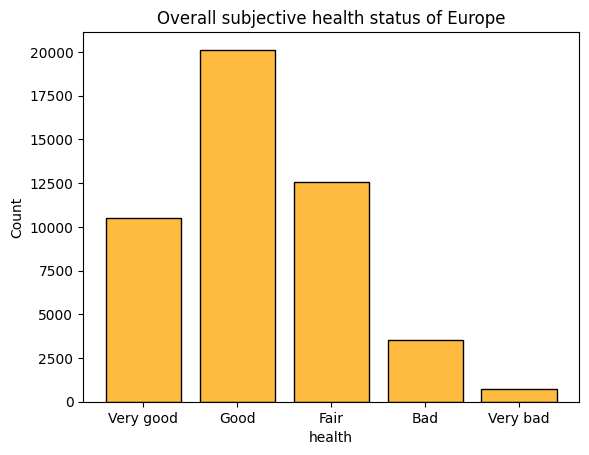

In [14]:
## Overall health status of Europe

sns.histplot(data = filtered_df[filtered_df['health'] < 6], x='health', color='orange',
             shrink=0.8, discrete = True)
plt.xticks(range(1, 6), ['Very good', 'Good', 'Fair', 'Bad', 'Very bad'])
plt.title('Overall subjective health status of Europe')

'''
Although the rating is subjective (each person has a different
subjective viewpoint), the overall health status of Europe is concentrated
around 1-3, which is, in general, not very good.
'''

# Correlation checking
 

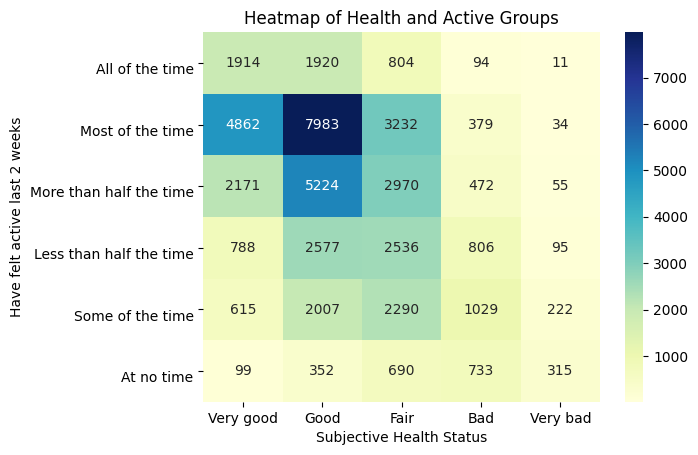

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001783C33A200> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
## The dataset suggests that 'health' is surveyed on a scale of 1-5
## And 'actvgrs' or "active and vigorous" is surveyed on a scale of 1-6
## In both cases, 1 being the best (healthiest / most active) and 5/6 being the worst (very unhealthy / Was active at no time).
combined_df = filtered_df[['health', 'actvgrs']].dropna()
clean_df = combined_df[(combined_df['health'] < 6) & (combined_df['actvgrs'] < 7)] 

sns.heatmap(pd.crosstab(clean_df['actvgrs'], clean_df['health']), annot=True, cmap='YlGnBu', fmt='d')
plt.title("Heatmap of Health and Active Groups")
plt.ylabel("Have felt active last 2 weeks")
plt.xlabel("Subjective Health Status", rotation=0)
plt.yticks(np.arange(6) + 0.5, labels=["All of the time", 
                                       "Most of the time", 
                                       "More than half the time", 
                                       "Less than half the time",
                                       "Some of the time", 
                                       "At no time"], rotation = 30, ha='right', va='top')
plt.xticks(np.arange(5) + 0.5, ['Very good', 'Good', 'Fair', 'Bad', 'Very bad'])
plt.yticks(rotation=0)
plt.show()

'''
The heatmap shows that people who are opted to be active and vigorous
are more likely to rate their health as "very good" or "good".
'''



In [52]:

'''
This can also be visualized through a scatter plot with
overlapping points spreaded in a sense that there are many
points overlapping at the same location.
'''

# sns.scatterplot(x='health', y='actvgrs', data=clean_df, alpha=0.5, color='orange')
# sns.stripplot(x='health', y='actvgrs', data=clean_df, alpha=0.5, color='orange', jitter=True)
sns.swarmplot(x='health', y='actvgrs', data=clean_df, alpha=0.1, size=2.5)
plt.title("Correlation between Sense of Subjective Health and Self-will of activeness")




KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001783C33A200> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 